In [ ]:
# Install dependencies if not already installed
!pip install opencv-python
!pip install deepface
!pip install scikit-image
!pip install scikit-learn-intelex
!pip install matplotlib

In [1]:
# Imports
import os
import cv2
import pickle
from deepface import DeepFace

import pandas as pd
import numpy as np

from sklearnex import patch_sklearn 
patch_sklearn()

from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Mask Detection Code

### Setting up the Dataset

In [23]:
# References: CPSC330 lectures https://github.com/UBC-CS/cpsc330-2022W2/tree/main/lectures/Giulia
# and https://medium.com/analytics-vidhya/image-classification-using-machine-learning-support-vector-machine-svm-dc7a0ec92e01

# Set up the dataset. 
categories = ["with_mask", "without_mask"]
flattened_data_arr=[]
target_data_arr=[]

dataset_dir='Mask Detection Dataset'

for i in categories:
    path=os.path.join(dataset_dir, i)
    for img in os.listdir(path):
        if img.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.jfif')):
            img_arr = imread(os.path.join(path, img))
            img_resized = resize(img_arr,(150,150,3))
            flattened_data_arr.append(img_resized.flatten())
            target_data_arr.append(categories.index(i))
flat_data=np.array(flattened_data_arr)
target=np.array(target_data_arr)
df=pd.DataFrame(flat_data)
df['y']=target

In [24]:
# Split the dataset
X=df.iloc[:,:-1]
y=df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

### Setting Up a Model (First Prototype, No Optimization)

In [ ]:
# # Create an initial model in case hyperparamter optimization takes too long
# hyperparameters = {'C': [1],
#                    'gamma': [1]}

# svc = svm.SVC(probability=True)

# model = GridSearchCV(svc, hyperparameters)
# model.fit(X_train, y_train)

# pickle.dump(model, open('first_img_model.p','wb'))
# print("Saved model to first_img_model.p")

In [2]:
with open('first_img_model.p', 'rb') as pickle_file:
    model = pickle.load(pickle_file)
    
categories = ["with_mask", "without_mask"]

In [25]:
pred = model.predict(X_test)
accuracy = accuracy_score(pred, y_test)
accuracy

0.9230769230769231

### Setting Up a Model (With Optimization)

In [ ]:
# Fit the model and find good hyperparameters
hyperparameters = {'C':[0.1, 1, 10, 100],
                   'gamma':[0.0001, 0.001, 0.1, 1]}

svc=svm.SVC(probability=True)

model = GridSearchCV(svc, hyperparameters)
model.fit(X_train, y_train)
model.best_params_

In [ ]:
pickle.dump(model, open('img_model.p','wb'))
print("Saved model to img_model.p")

### Function for Checking Mask

In [3]:
# Dataset taken from https://github.com/chandrikadeb7/Face-Mask-Detection
def check_mask(path, model=None):
    if not model:
        with open('first_img_model.p', 'rb') as pickle_file:
            model = pickle.load(pickle_file)
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # cv2 doesn't use RGB, it uses BGR
    resized_image =resize(image,(150,150,3))
    return model.predict([resized_image.flatten()])[0]


In [11]:
result = check_mask("Mask Detection Dataset/with_mask/with_mask509.jpg", model)
categories[result]

'with_mask'

## Face Recognition Code

In [6]:
deepface_models = [
  "VGG-Face", 
  "Facenet", 
  "Facenet512", 
  "OpenFace", 
  "DeepFace", 
  "DeepID", 
  "ArcFace", 
  "Dlib", 
  "SFace",
]

categories = ["with_mask", "without_mask"]

def verify_guest(path, room_num, model):
    is_unmasked = check_mask(path, model)
    if not is_unmasked:
        return 0, "Please take off your face mask and try again." # Mask detected
    else:
        room_dir = f"Face Recognition Data/room_{room_num}"
        # Iterate through each photo in the list of registered guests
        for filename in os.listdir(room_dir):
            f = os.path.join(room_dir, filename)
            if os.path.isfile(f):
                curr_result = DeepFace.verify(img1_path = path, 
                                  img2_path = f, 
                                  model_name = deepface_models[0]
                              )
                if curr_result["verified"]:
                    return 1, "Welcome, guest."
    return 0, "Please try again." # No match

## Prototype Test

Before running the cells below:
- Run imports
- Load the model
- Run the function cells

#### Obama with Mask

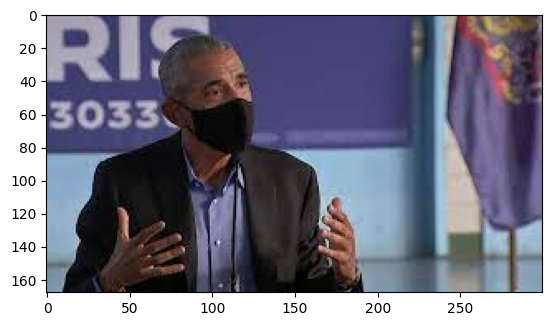

In [19]:
img = cv2.imread('Face Recognition Data/test_inputs/room_1/obama_mask.jfif', 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 doesn't use RGB, it uses BGR
imgplot = plt.imshow(img)
plt.show()

In [20]:
verify_guest("Face Recognition Data/test_inputs/room_1/obama_mask.jfif", 1, model)

(0, 'Please take off your face mask and try again.')

#### Obama without Mask

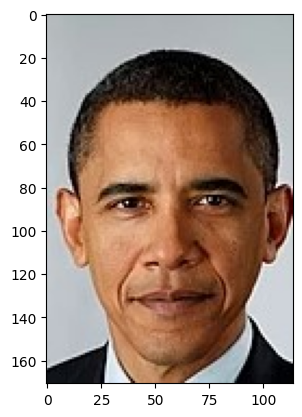

In [21]:
img = cv2.imread('Face Recognition Data/test_inputs/room_1/obama_2_cropped.jpg', 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 doesn't use RGB, it uses BGR
imgplot = plt.imshow(img)
plt.show()

In [22]:
verify_guest("Face Recognition Data/test_inputs/room_1/obama_2.jpg", 1, model)

(0, 'Please take off your face mask and try again.')

## Prototype Findings
- This model achieved **92% accuracy with the test set**.
- Optimization has not been performed yet due to time restraints for the prototype but will be done for the final product
- Despite such great accuracy with the test set, we did not see an accurate prediction for the picture of Obama above
    - Need to look into whether this is an issue with the image I grabbed for Obama or if this is an issue for my model
- Runtime for verify_guest (which also runs mask detection) is **very fast**, significantly < 1s!
    
## Next Steps
- Hyperparameter optimization
- Data augmentation for more samples
    - Looking into data augmentation to improve accuracy for new pictures